# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

##**Loading Libraries & Data**


In [73]:
import pandas as pd
pd.set_option("display.max_colwidth", 180) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import math


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import string
import re
import nltk
from nltk.stem.porter import PorterStemmer

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Importing Data
file_path = '/content/drive/MyDrive/Coronavirus Tweets.csv'
df = pd.read_csv(file_path,encoding='latin-1')

##**Exploring Data**

In [4]:
df = df.rename(columns = {'TweetAt': 'Date'})

In [5]:
df.head()

,UserName,ScreenName,Location,Date,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay cal...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious th...",Extremely Negative


In [6]:
df.tail()

,UserName,ScreenName,Location,Date,OriginalTweet,Sentiment
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket shelves in #NZ lockdown #COVID-19 https://t.co/cz89uA0HNp,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVID-19 related delays. Yet prompt in rejecting policy before consumer TAT is over. Way to go ?,Extremely Negative
41154,44953,89905,NaN,14-04-2020,"You know itÂs getting tough when @KameronWilds is rationing toilet paper #coronavirus #toiletpaper @kroger martinsville, help us out!!",Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer is starting to turn me on?\r\r\n\r\r\n#coronavirus #COVID19 #coronavirus,Neutral
41156,44955,89907,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for $700.00 on Amazon rn although the normal market price is usually $400.00 . Prices are really crazy right now for vr headsets since...,Negative


In [7]:
df.shape

(41157, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   Date           41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [9]:
df.describe()

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


Checking if there exists any NULL in the data.

In [10]:
print(df.isnull().sum())

UserName            0
ScreenName          0
Location         8590
Date                0
OriginalTweet       0
Sentiment           0
dtype: int64


## **Data Visualization**

As we can see around 8590 are the total null and some gibberish values are present in Location column but its okay because as we are doing sentiment analysis we do not need Location column, so its not important though we will do basic EDA.

In [11]:
#Top 10 Locations of Tweets
top10_loc = df['Location'].value_counts().head(10)
top10_loc

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

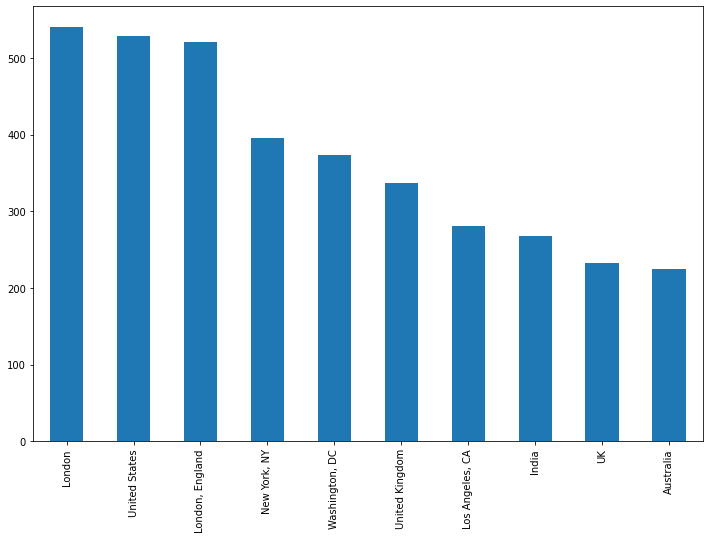

In [12]:
#Bar Graph for top 10 location analysis
df['Location'].value_counts().head(10).plot.bar(figsize=(12,8))

In [13]:
#dates column is also not imporatant for us
df.Date.unique()

array(['16-03-2020', '17-03-2020', '18-03-2020', '19-03-2020',
       '20-03-2020', '21-03-2020', '22-03-2020', '23-03-2020',
       '24-03-2020', '25-03-2020', '26-03-2020', '27-03-2020',
       '28-03-2020', '29-03-2020', '30-03-2020', '31-03-2020',
       '01-04-2020', '02-04-2020', '03-04-2020', '04-04-2020',
       '05-04-2020', '06-04-2020', '07-04-2020', '08-04-2020',
       '09-04-2020', '10-04-2020', '11-04-2020', '12-04-2020',
       '13-04-2020', '14-04-2020'], dtype=object)

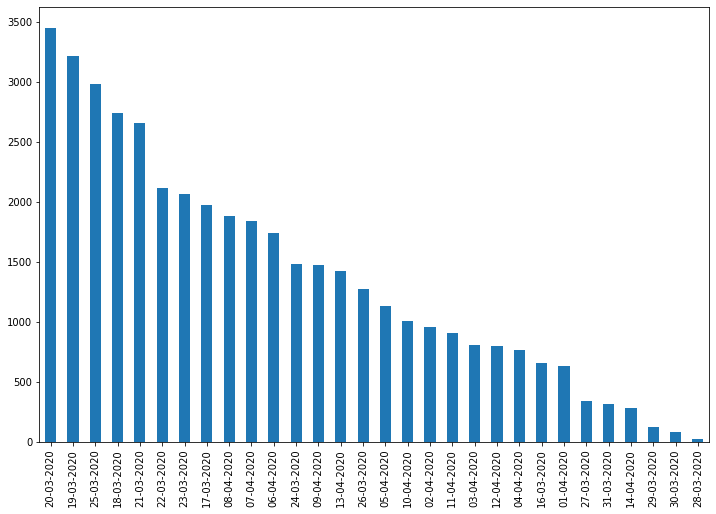

In [14]:
#Bar Graph for Date column
df['Date'].value_counts().plot.bar(figsize=(12,8))

In [15]:
#Analysis on Sentiment Column
df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

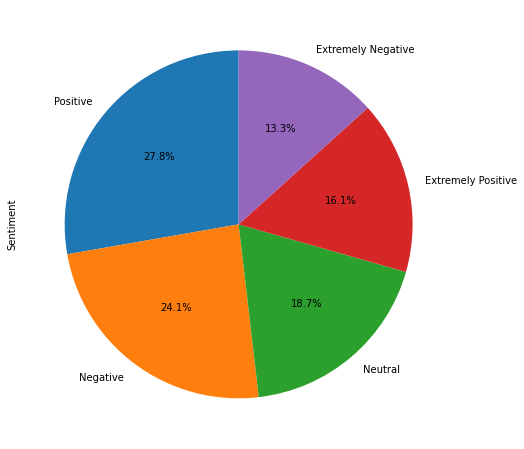

In [16]:
#Pie Chart of Sentiment Analysis
df['Sentiment'].value_counts().plot(kind='pie',
                              figsize=(15,8),
                               autopct="%1.1f%%",
                               startangle=90)

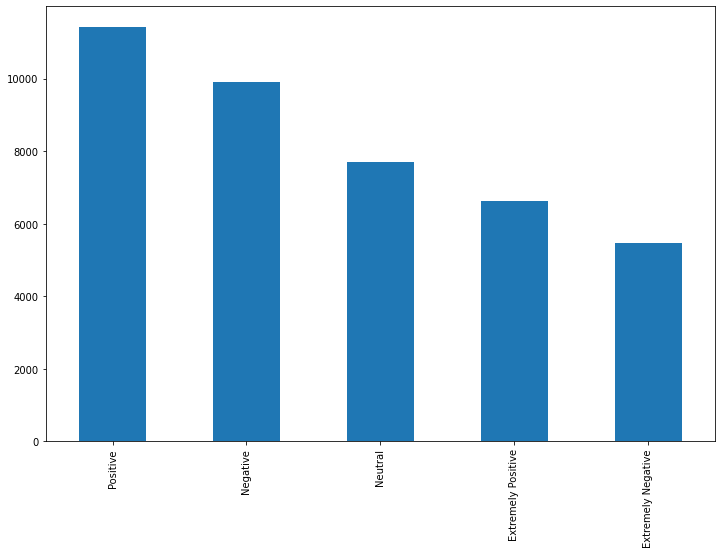

In [17]:
#Bar Graph of Sentiment Analysis
df['Sentiment'].value_counts().plot.bar(figsize=(12,8))

## **Text Preprocessing**

**1. Removing URLs and @Users**

In [18]:
df['cleaned_Tweet'] = df['OriginalTweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [19]:
df['cleaned_Tweet'] = df['cleaned_Tweet'].apply(lambda x: re.split('@[\w]*', str(x))[0])

In [20]:
df.head(3)

,UserName,ScreenName,Location,Date,OriginalTweet,Sentiment,cleaned_Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"


**2. Removing Punctuation & Numbers**



In [21]:
df['cleaned_Tweet'] = df['cleaned_Tweet'].apply(lambda x: re.sub('[^A-Za-z0-9]', ' ', x))
df['cleaned_Tweet'] = df['cleaned_Tweet'].str.replace('\d+', '')

In [22]:
df.head(3)

,UserName,ScreenName,Location,Date,OriginalTweet,Sentiment,cleaned_Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID outbreak


**3. Tokenization**

In [23]:
def tokenize(txt):
  tokens = re.split('\W+', txt)
  return tokens

In [24]:
tokenized_tweet = df['cleaned_Tweet'].apply(lambda x: tokenize(x.lower()))

In [25]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

In [26]:
tokenized_tweet.head(5)

0                                                                                                                                                                                       
1    advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts...
2                                                                                coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak 
3    my food stock is not the only one which is empty please don t panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covidfrance...
4    me ready to go at supermarket during the covid outbreak not because i m paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please don ...
Name: cleaned_Tweet, dtype: object

In [27]:
df['cleaned_Tweet']  = tokenized_tweet

**3. Removing Stop words**

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [30]:
df['cleaned_Tweet'].apply(lambda x: [item for item in x if item not in stopwords])

0                                                                                                                                                                                         []
1        [v, c, e,  , l, k,  ,  , u, r,  , n, e, g, h, b, u, r,  , f, l,  ,  , e, x, c, h, n, g, e,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e, e,  , c, n, c,  , l,  , w, h,  , p, h, n...
2                   [c, r, n, v, r, u,  , u, r, l,  , w, l, w, r, h,  ,  , g, v, e,  , e, l, e, r, l,  , b, l, e,  , e, c, e,  , h, p, p, n, g,  , h, u, r,  ,  , c, v,  , u, b, r, e, k,  ]
3        [ , f,  , c, k,  ,  , n,  , h, e,  , n, l,  , n, e,  , w, h, c, h,  ,  , e, p,  , p, l, e, e,  , n,  ,  , p, n, c,  , h, e, r, e,  , w, l, l,  , b, e,  , e, n, u, g, h,  , f,  ...
4        [e,  , r, e,  ,  , g,  ,  , u, p, e, r, r, k, e,  , u, r, n, g,  , h, e,  , c, v,  , u, b, r, e, k,  , n,  , b, e, c, u, e,  ,  ,  , p, r, n,  , b, u,  , b, e, c, u, e,  ,  , f...
                                                       

In [31]:
df.head(3)

,UserName,ScreenName,Location,Date,OriginalTweet,Sentiment,cleaned_Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts...,Positive,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak


**4. Stemming**

In [32]:
ps = PorterStemmer()

In [33]:
stemming = df['cleaned_Tweet'].apply(lambda x: [ps.stem(i) for i in x])

In [34]:
for i in range(len(stemming)):
    stemming[i] = ''.join(stemming[i])

In [35]:
df['cleaned_Tweet']  = stemming

In [36]:
df.head(3)

,UserName,ScreenName,Location,Date,OriginalTweet,Sentiment,cleaned_Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts...,Positive,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak


Now our Tweet Column is cleaned so before moving towards vectorization we will do some basic EDA.

*Frequent words are used in tweets* 

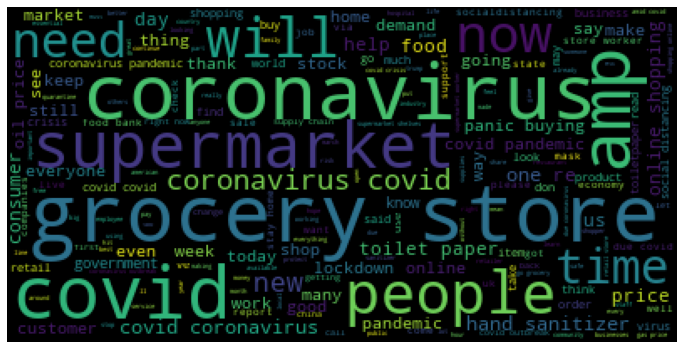

In [37]:
words_ = ' '.join([text for text in df['cleaned_Tweet']])

wordcloud = WordCloud().generate(words_)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

*Frequent words are used in tweets by users where sentiments are Extremely Positive* 

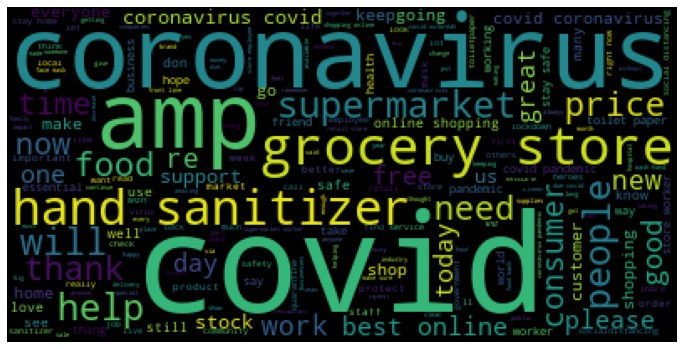

In [38]:
epositive_words = ' '.join([text for text in df['cleaned_Tweet'][df['Sentiment'] == 'Extremely Positive']])

wordcloud = WordCloud().generate(epositive_words)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

*Frequent words are used in tweets by users where sentiments are Positive* 

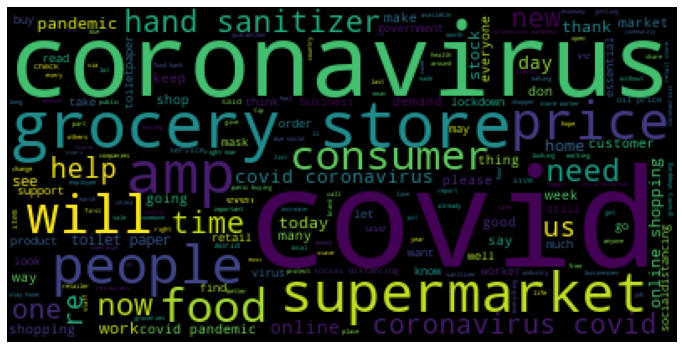

In [39]:
positive_words = ' '.join([text for text in df['cleaned_Tweet'][df['Sentiment'] == 'Positive']])

wordcloud = WordCloud().generate(positive_words)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

*Frequent words are used in tweets by users where sentiments are Neutral* 

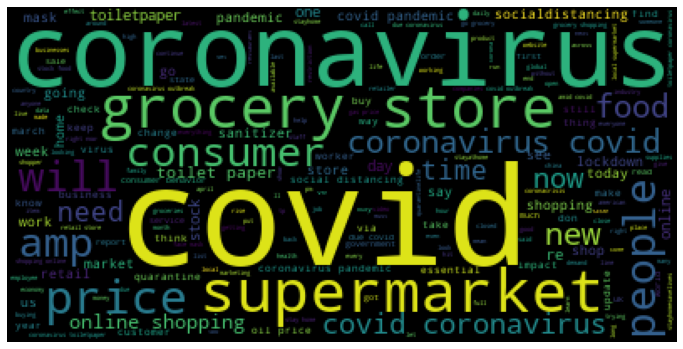

In [40]:
n_words = ' '.join([text for text in df['cleaned_Tweet'][df['Sentiment'] == 'Neutral']])

wordcloud = WordCloud().generate(n_words)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

*Frequent words are used in tweets by users where sentiments are Negative* 

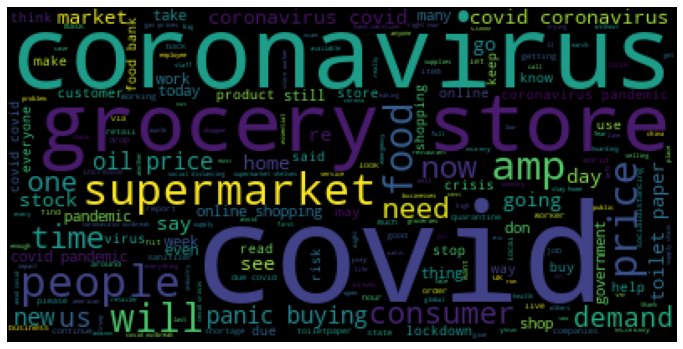

In [41]:
negative_words = ' '.join([text for text in df['cleaned_Tweet'][df['Sentiment'] == 'Negative']])

wordcloud = WordCloud().generate(negative_words)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

*Frequent words are used in tweets by users where sentiments are Extremely Negative* 

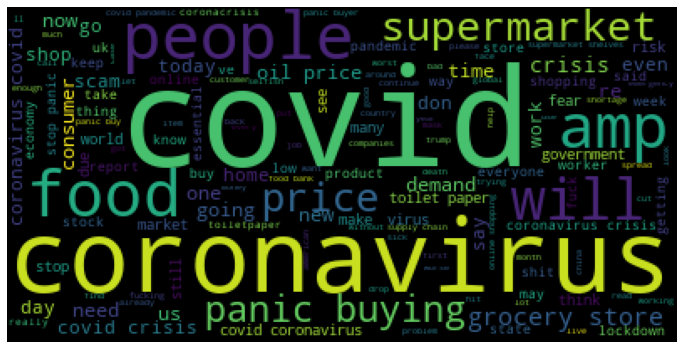

In [42]:
enegative_words = ' '.join([text for text in df['cleaned_Tweet'][df['Sentiment'] == 'Extremely Negative']])

wordcloud = WordCloud().generate(enegative_words)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# **Modeling (Multiclass Classification)**

In [103]:
new_df = df[['cleaned_Tweet','Sentiment']]
new_df.head(3)

,cleaned_Tweet,Sentiment
0,,Neutral
1,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts...,Positive
2,coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak,Positive


## Vectorization & Train Test Split

In [44]:
#Splitting into train test split
train,test = train_test_split(new_df,test_size = 0.25,random_state=0,stratify = new_df.Sentiment.values)

In [48]:
#Vectorizing
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.cleaned_Tweet.values)
X_test = vectorizer.transform(test.cleaned_Tweet.values)

y_train = train.Sentiment.values
y_test = test.Sentiment.values


## Logistic Regression

In [49]:
#Fitting Model
reg = LogisticRegression()

reg.fit(X_train, y_train)

reg_pred = reg.predict(X_test)
reg_accuracy = accuracy_score(y_test,reg_pred)

In [50]:
print("Training accuracy Score    : ",reg.score(X_train,y_train))
print("Test accuracy Score : ",reg_accuracy )

Training accuracy Score    :  0.8563514432889494
Test accuracy Score :  0.5402332361516035


In [51]:
print(classification_report(reg_pred,y_test))

                    precision    recall  f1-score   support

Extremely Negative       0.51      0.63      0.56      1100
Extremely Positive       0.50      0.64      0.56      1296
          Negative       0.46      0.52      0.49      2212
           Neutral       0.58      0.60      0.59      1872
          Positive       0.62      0.46      0.53      3810

          accuracy                           0.54     10290
         macro avg       0.53      0.57      0.55     10290
      weighted avg       0.55      0.54      0.54     10290



## Random Forest Classifier

In [55]:
#Fitting Model
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test,rf_pred)

In [56]:
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Test accuracy Score : ",rf_accuracy )

Training accuracy Score    :  0.9164155894644767
Test accuracy Score :  0.5000971817298347


In [57]:
print(classification_report(rf_pred,y_test))

                    precision    recall  f1-score   support

Extremely Negative       0.35      0.68      0.46       712
Extremely Positive       0.31      0.64      0.42       803
          Negative       0.43      0.50      0.46      2129
           Neutral       0.68      0.52      0.59      2510
          Positive       0.62      0.43      0.51      4136

          accuracy                           0.50     10290
         macro avg       0.48      0.55      0.49     10290
      weighted avg       0.55      0.50      0.51     10290



## Naive Bayes Classifier

In [52]:
#Fitting Model
naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_pred = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_pred)


In [53]:
print("Training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Test accuracy Score : ",NB_accuracy )

Training accuracy Score    :  0.6933294456863317
Test accuracy Score :  0.4434402332361516


In [54]:
print(classification_report(NB_pred,y_test))

                    precision    recall  f1-score   support

Extremely Negative       0.31      0.57      0.40       762
Extremely Positive       0.36      0.55      0.43      1078
          Negative       0.45      0.42      0.44      2625
           Neutral       0.30      0.64      0.41       898
          Positive       0.65      0.38      0.48      4927

          accuracy                           0.44     10290
         macro avg       0.41      0.51      0.43     10290
      weighted avg       0.51      0.44      0.45     10290



## SGD Classifier

In [64]:
#Fitting Model
sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l1', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_pred = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_pred)

In [65]:
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Test accuracy Score : ",sgd_accuracy )

Training accuracy Score    :  0.6250688437489876
Test accuracy Score :  0.5050534499514091


In [66]:
print(classification_report(sgd_pred,y_test))

                    precision    recall  f1-score   support

Extremely Negative       0.60      0.55      0.57      1514
Extremely Positive       0.60      0.56      0.58      1756
          Negative       0.44      0.39      0.41      2828
           Neutral       0.68      0.58      0.62      2266
          Positive       0.35      0.51      0.41      1926

          accuracy                           0.51     10290
         macro avg       0.53      0.52      0.52     10290
      weighted avg       0.53      0.51      0.51     10290



## Xtreme Gradient Boosting

In [70]:
#Fitting Model
xgb_clf = xgb.XGBClassifier()

xgb_clf.fit(X_train, y_train)

xgb_pred = xgb_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_pred)

In [71]:
print("Training accuracy Score    : ",xgb_clf.score(X_train,y_train))
print("Test accuracy Score : ",xgb_accuracy )

Training accuracy Score    :  0.42858068487381346
Test accuracy Score :  0.4172983479105928


In [72]:
print(classification_report(xgb_pred,y_test))

                    precision    recall  f1-score   support

Extremely Negative       0.35      0.62      0.45       776
Extremely Positive       0.35      0.65      0.45       881
          Negative       0.34      0.45      0.39      1864
           Neutral       0.13      0.46      0.20       543
          Positive       0.75      0.34      0.47      6226

          accuracy                           0.42     10290
         macro avg       0.38      0.51      0.39     10290
      weighted avg       0.58      0.42      0.44     10290



## Support Vector Machine

In [76]:
#Fitting Model
svc = SVC()

svc.fit(X_train, y_train)

svc_pred = svc.predict(X_test)
svc_accuracy = accuracy_score(y_test,svc_pred)

In [77]:
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Test accuracy Score : ",svc_accuracy )

Training accuracy Score    :  0.8326691936372177
Test accuracy Score :  0.5210884353741496


In [78]:
print(classification_report(svc_pred,y_test))

                    precision    recall  f1-score   support

Extremely Negative       0.36      0.71      0.48       694
Extremely Positive       0.37      0.76      0.50       814
          Negative       0.47      0.52      0.49      2214
           Neutral       0.55      0.58      0.56      1848
          Positive       0.71      0.43      0.54      4720

          accuracy                           0.52     10290
         macro avg       0.49      0.60      0.51     10290
      weighted avg       0.58      0.52      0.52     10290



## Models Accuracy Result

In [84]:
result = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SGD', 'XGBoost' , 'Support Vector Machine'],
    'Result accuracy' : [reg_accuracy, rf_accuracy, NB_accuracy, sgd_accuracy, xgb_accuracy,svc_accuracy]
    })
              
result.sort_values(by='Result accuracy', ascending=False)

,Model,Result accuracy
0,Logistic Regression,0.540233
5,Support Vector Machine,0.521088
3,SGD,0.505053
1,Random Forest,0.500097
2,Naive Bayes,0.443440
4,XGBoost,0.417298


# **Modeling (Binary Classification)**

We will change Multi Class into Binary Class & perform and fit models again to see the result.

In [92]:
new_df2 = new_df[['cleaned_Tweet','Sentiment']]

In [93]:
new_df2["Sentiment"]= new_df2["Sentiment"].replace('Extremely Positive',1) 
new_df2["Sentiment"]= new_df2["Sentiment"].replace('Positive',1) 
new_df2["Sentiment"]= new_df2["Sentiment"].replace('Neutral',0) 
new_df2["Sentiment"]= new_df2["Sentiment"].replace('Negative',-1) 
new_df2["Sentiment"]= new_df2["Sentiment"].replace('Extremely Negative',-1) 

In [97]:
new_df2.head()

,cleaned_Tweet,Sentiment
0,,0
1,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts...,1
2,coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak,1
3,my food stock is not the only one which is empty please don t panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covidfrance...,1
4,me ready to go at supermarket during the covid outbreak not because i m paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please don ...,-1


## Vectorization & Train Test Split

In [98]:
#Splitting into train test split
train,test = train_test_split(new_df2,test_size = 0.25,random_state=0,stratify = new_df.Sentiment.values)

In [99]:
#Vectorizing
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.cleaned_Tweet.values)
X_test = vectorizer.transform(test.cleaned_Tweet.values)

y_train = train.Sentiment.values
y_test = test.Sentiment.values


## Logistic Regression

In [100]:
#Fitting Model
reg = LogisticRegression()

reg.fit(X_train, y_train)

reg_pred = reg.predict(X_test)
reg_accuracy = accuracy_score(y_test,reg_pred)

In [101]:
print("Training accuracy Score    : ",reg.score(X_train,y_train))
print("Test accuracy Score : ",reg_accuracy )

Training accuracy Score    :  0.899731104415719
Test accuracy Score :  0.7381924198250729


In [102]:
print(classification_report(reg_pred,y_test))

              precision    recall  f1-score   support

          -1       0.71      0.80      0.75      3396
           0       0.56      0.65      0.60      1667
           1       0.84      0.73      0.78      5227

    accuracy                           0.74     10290
   macro avg       0.70      0.73      0.71     10290
weighted avg       0.75      0.74      0.74     10290



In [ ]:
#Fitting Model
reg = LogisticRegression()

reg.fit(X_train, y_train)

reg_pred = reg.predict(X_test)
reg_accuracy = accuracy_score(y_test,reg_pred)

In [ ]:
print("Training accuracy Score    : ",reg.score(X_train,y_train))
print("Test accuracy Score : ",reg_accuracy )

Training accuracy Score    :  0.8563514432889494
Test accuracy Score :  0.5402332361516035


In [ ]:
print(classification_report(reg_pred,y_test))

                    precision    recall  f1-score   support

Extremely Negative       0.51      0.63      0.56      1100
Extremely Positive       0.50      0.64      0.56      1296
          Negative       0.46      0.52      0.49      2212
           Neutral       0.58      0.60      0.59      1872
          Positive       0.62      0.46      0.53      3810

          accuracy                           0.54     10290
         macro avg       0.53      0.57      0.55     10290
      weighted avg       0.55      0.54      0.54     10290



## Random Forest Classifier

In [104]:
#Fitting Model
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test,rf_pred)

In [105]:
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Test accuracy Score : ",rf_accuracy )

Training accuracy Score    :  0.9362425891729032
Test accuracy Score :  0.6979591836734694


In [106]:
print(classification_report(rf_pred,y_test))

              precision    recall  f1-score   support

          -1       0.63      0.77      0.69      3140
           0       0.57      0.60      0.59      1846
           1       0.81      0.69      0.75      5304

    accuracy                           0.70     10290
   macro avg       0.67      0.69      0.67     10290
weighted avg       0.71      0.70      0.70     10290



## Naive Bayes Classifier

In [107]:
#Fitting Model
naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_pred = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_pred)


In [108]:
print("Training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Test accuracy Score : ",NB_accuracy )

Training accuracy Score    :  0.7667087828425179
Test accuracy Score :  0.6501457725947521


In [109]:
print(classification_report(NB_pred,y_test))

              precision    recall  f1-score   support

          -1       0.67      0.69      0.68      3750
           0       0.21      0.65      0.32       627
           1       0.82      0.63      0.71      5913

    accuracy                           0.65     10290
   macro avg       0.57      0.66      0.57     10290
weighted avg       0.73      0.65      0.68     10290



## SGD Classifier

In [110]:
#Fitting Model
sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l1', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_pred = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_pred)

In [111]:
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Test accuracy Score : ",sgd_accuracy )

Training accuracy Score    :  0.8097644733858166
Test accuracy Score :  0.7740524781341108


In [112]:
print(classification_report(sgd_pred,y_test))

              precision    recall  f1-score   support

          -1       0.72      0.84      0.77      3310
           0       0.67      0.71      0.69      1826
           1       0.86      0.76      0.81      5154

    accuracy                           0.77     10290
   macro avg       0.75      0.77      0.76     10290
weighted avg       0.78      0.77      0.78     10290



## Xtreme Gradient Boosting

In [113]:
#Fitting Model
xgb_clf = xgb.XGBClassifier()

xgb_clf.fit(X_train, y_train)

xgb_pred = xgb_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_pred)

In [114]:
print("Training accuracy Score    : ",xgb_clf.score(X_train,y_train))
print("Test accuracy Score : ",xgb_accuracy )

Training accuracy Score    :  0.5911167266012246
Test accuracy Score :  0.5913508260447036


In [115]:
print(classification_report(xgb_pred,y_test))

              precision    recall  f1-score   support

          -1       0.52      0.74      0.61      2720
           0       0.02      0.54      0.04        83
           1       0.89      0.54      0.67      7487

    accuracy                           0.59     10290
   macro avg       0.48      0.61      0.44     10290
weighted avg       0.79      0.59      0.65     10290



## Support Vector Machine

In [116]:
#Fitting Model
svc = SVC()

svc.fit(X_train, y_train)

svc_pred = svc.predict(X_test)
svc_accuracy = accuracy_score(y_test,svc_pred)

In [117]:
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Test accuracy Score : ",svc_accuracy )

Training accuracy Score    :  0.8782194576732433
Test accuracy Score :  0.7050534499514092


In [118]:
print(classification_report(svc_pred,y_test))

              precision    recall  f1-score   support

          -1       0.65      0.78      0.71      3218
           0       0.49      0.62      0.55      1519
           1       0.84      0.68      0.75      5553

    accuracy                           0.71     10290
   macro avg       0.66      0.70      0.67     10290
weighted avg       0.73      0.71      0.71     10290



## Models Accuracy Result

In [120]:
result = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SGD [Winner]', 'XGBoost' , 'Support Vector Machine'],
    'Result accuracy' : [reg_accuracy, rf_accuracy, NB_accuracy, sgd_accuracy, xgb_accuracy,svc_accuracy]
    })
              
result.sort_values(by='Result accuracy', ascending=False)

,Model,Result accuracy
3,SGD [Winner],0.774052
0,Logistic Regression,0.738192
5,Support Vector Machine,0.705053
1,Random Forest,0.697959
2,Naive Bayes,0.650146
4,XGBoost,0.591351


# **Conclusion**

We have used various models for our Sentiment Analysis and done both Multiclass Classification  and Binary Classification. In Multiclass Classfication our models were not giving good results comparing to Binary Classfication. 
<br>
<br>SGD model has given higest number of accuracy rather than any other models.

